In [26]:
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import date, datetime, timedelta, UTC
import matplotlib.pyplot as plt
from prophet import Prophet
import yfinance as yf
from prophet.serialize import model_to_json, model_from_json

In [5]:
client = Client()

In [6]:
def get_binance_data(symbol='BTCUSDT', interval='5m', lookback = '300 days'):
    now = datetime.now(UTC)
    past = now - pd.to_timedelta(lookback)

    df = pd.DataFrame(client.get_historical_klines(symbol, interval, str(past), str(now)
    ), columns=['open_time','Open', 'High', 'Low', 'Close', 'Volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol','is_best_match'])
    
    df['Date']= pd.to_datetime(df['open_time'], unit='ms')
    return df[['Date','Open', 'High', 'Low', 'Close', 'Volume']]  

In [7]:
%%time
data = get_binance_data(interval='5m')

CPU times: user 616 ms, sys: 94.6 ms, total: 711 ms
Wall time: 55.9 s


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    86400 non-null  datetime64[ns]
 1   Open    86400 non-null  object        
 2   High    86400 non-null  object        
 3   Low     86400 non-null  object        
 4   Close   86400 non-null  object        
 5   Volume  86400 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 4.0+ MB


In [9]:
data.to_csv('Data_set_for_analitics_5min.csv')

In [10]:
# Forecasting
df_train = data[['Date', 'Open']]
df_train = df_train.astype({'Open':'float'})
df_train = df_train.rename(columns={"Date": "ds", 'Open': "y"})

In [51]:
## Creating model parameters
model_param ={
    "n_changepoints": 100, # fewer changepoints speed up predictions
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": False,
    "seasonality_mode": "multiplicative",
    "changepoint_prior_scale": 0.1,
    "seasonality_prior_scale": 10.0,
    "holidays_prior_scale": 10.0,
    "growth": "logistic" #or linear.Then will need to delete cap paremeter/linear is by default
}
m = Prophet(**model_param)  #**model_param
df_train['cap']= df_train["y"].max() + df_train["y"].std() * 0.05
m.add_country_holidays(country_name='US')
m.add_seasonality(name='dayly', period=1, fourier_order=10)
m.add_seasonality(name='weekly', period=7, fourier_order=6)
m.add_seasonality(name='hourly', period=1/24, fourier_order=5)

In [52]:
m.fit(df_train.iloc[-15000:]) #

15:34:43 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
with open('serialized_model_Prophet_5min.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model#save the model if needed with serialization

In [54]:
with open('serialized_model_Prophet_5min.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model #load the model if needed

In [55]:
future = m.make_future_dataframe(periods=288, freq='5min') #5 minutes
future['cap'] = df_train['cap'].max()
#forecast = m.predict(future, parallel="threads")
forecast = m.predict(future)

In [56]:
result = forecast.merge(
    data[['Date', 'Open']], 
    left_on='ds',         
    right_on='Date',       
    how='left'               
)

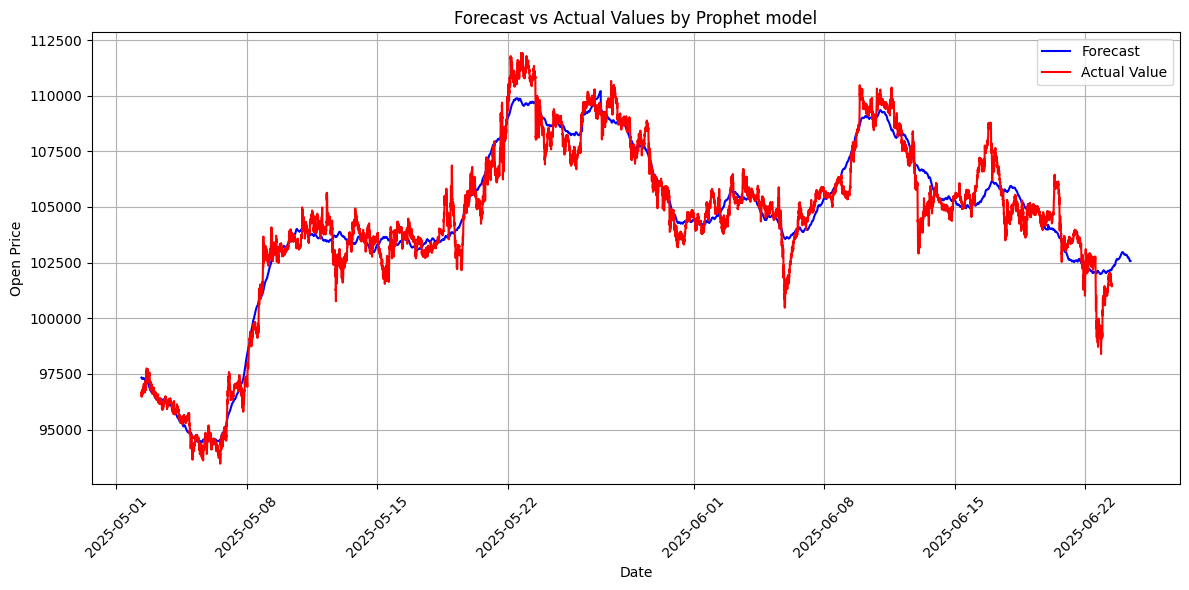

In [59]:
plt.figure(figsize=(12, 6))
result['Open'] = pd.to_numeric(result['Open'])
plt.plot(result['ds'], result['yhat'], 'b-', label='Forecast')
plt.plot(result['ds'], result['Open'], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Open Price')
plt.title('Forecast vs Actual Values by Prophet model')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Prevent label cutoff
plt.show()

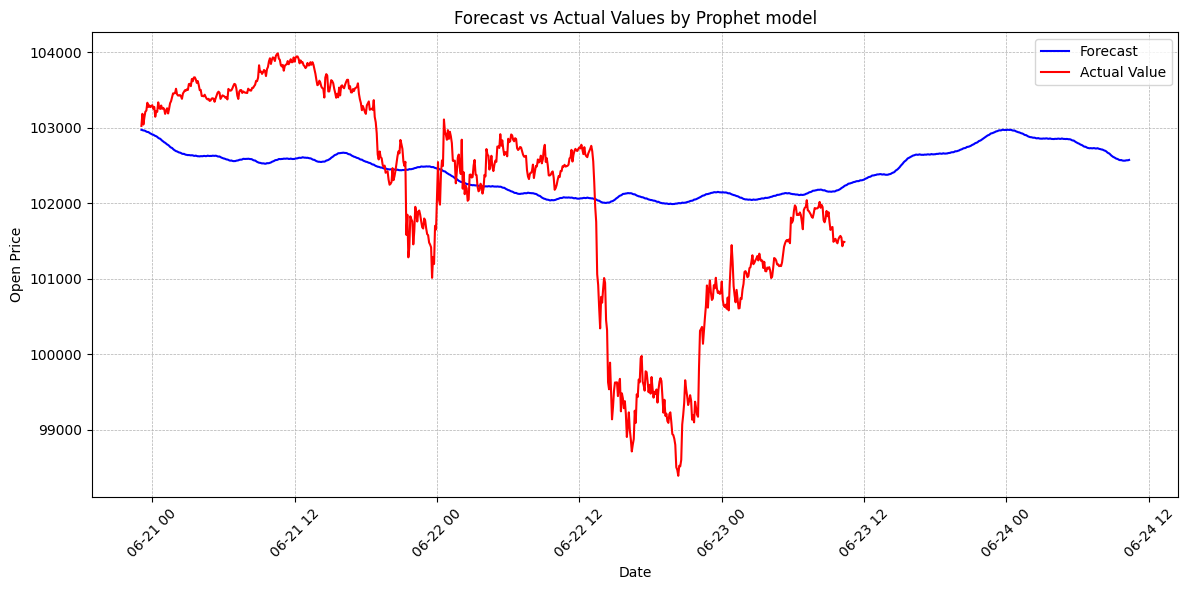

In [60]:
plt.figure(figsize=(12, 6))
result['Open'] = pd.to_numeric(result['Open'])
plt.plot(result['ds'].iloc[-1000:], result['yhat'].iloc[-1000:], 'b-', label='Forecast')
plt.plot(result['ds'].iloc[-1000:], result['Open'].iloc[-1000:], 'r-', label='Actual Value')  # Changed label to string
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Open Price')
plt.title('Forecast vs Actual Values by Prophet model')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [29]:
result[['ds','yhat','Open','Date']].to_csv('forecast_course.csv' )